In [1]:
############################################################
# dna
#
# Common methods for dealing with dna sequnces
############################################################

############################################################
# fasta2dict
#
# Read a multifasta file into a dict.  Taking the whole line
# as the key.
#
# I've found this can be quite slow for some reason, even
# for a single fasta entry.
############################################################
def fasta2dict(fasta_file):
    fasta_dict = OrderedDict()
    header = ''

    for line in open(fasta_file):
        if line[0] == '>':
            #header = line.split()[0][1:]
            header = line[1:].rstrip()
            fasta_dict[header] = ''
        else:
            fasta_dict[header] += line.rstrip()

    return fasta_dict


############################################################
# rc
#
# Reverse complement sequence
############################################################
def rc(seq):
    return seq.translate(string.maketrans("ATCGatcg","TAGCtagc"))[::-1]


############################################################
# rc_file
#
# Reverse complement sequences in a file
############################################################
def rc_file(seq_file):
    seq = ''
    for line in open(seq_file):
        if line[0] == '>':
            # print last sequence
            if seq:
                print(seq.translate(string.maketrans("ATCGatcg","TAGCtagc"))[::-1])

            # print header
            print('%s_rc' % line.rstrip())
            seq = ''
        else:
            seq += line.rstrip()

    # print last sequence
    if seq:
        print(seq.translate(string.maketrans("ATCGatcg","TAGCtagc"))[::-1])


############################################################
# count_kmers
#
# Count kmers from forward and reverse strand
############################################################
def count_kmers(k, seq, all=False):
    kmers = {}
    N = len(seq)
    rc_seq = rc(seq)
    for i in range(N-k+1):
        # forward
        kmer = seq[i:i+k]
        if kmers.has_key(kmer):
            kmers[kmer] += 1
        else:
            kmers[kmer] = 1

        # reverse
        kmer = rc_seq[i:i+k]
        if kmers.has_key(kmer):
            kmers[kmer] += 1
        else:
            kmers[kmer] = 1

    # remove non-ACGT kmers
    nts = {'A':1, 'C':1, 'G':1, 'T':1}
    for kmer in kmers.keys():
        for nt in kmer:
            if not nts.has_key(nt):
                del kmers[kmer]
                break

    if all:
        # add zero count kmers
        for i in range(int(math.pow(4,k))):
            kmer = int2kmer(k,i)
            if not kmers.has_key(kmer):
                kmers[kmer] = 0

    return kmers


############################################################
# count_kmers_file
#
# Count kmers from forward and reverse strand
############################################################
def count_kmers_file(k, fasta_file, all=False):
    kmers = {}
    seq = None
    for line in open(fasta_file):
        if line[0] == '>':
            if seq:
                seq_kmers = count_kmers(k, seq, all)
                for kmer in seq_kmers:
                    kmers[kmer] = kmers.get(kmer,0) + seq_kmers[kmer]
            seq = ''
        else:
            seq += line.rstrip()

    seq_kmers = count_kmers(k, seq, all)
    for kmer in seq_kmers:
        kmers[kmer] = kmers.get(kmer,0) + seq_kmers[kmer]

    return kmers


############################################################
# int2kmer
#
# Map integers to kmers
############################################################
def int2kmer(k,num):
    nts = ['A','C','G','T']
    kmer = ''
    for x in range(k):
        b = int(math.pow(4, k-1-x))
        kmer += nts[num / b]
        num =  num % b
    return kmer


############################################################
# canonical_kmers
#
# Clean up a dict of kmer counts by combining kmers with
# their reverse complements.  All counts are then divided
# by 2.  Careful about palindromes.
############################################################
def canonical_kmers(kmers, return_all=False):
    canon_kmers = {}
    for kmer in kmers:
        kmer_rc = rc(kmer)

        if kmer < kmer_rc:
            # add current
            if canon_kmers.has_key(kmer):
                canon_kmers[kmer] += kmers[kmer] / 2.0
            else:
                canon_kmers[kmer] = kmers[kmer] / 2.0

        elif kmer_rc < kmer:
            # add current
            if canon_kmers.has_key(kmer_rc):
                canon_kmers[kmer_rc] += kmers[kmer] / 2.0
            else:
                canon_kmers[kmer_rc] = kmers[kmer] / 2.0

        elif kmer == kmer_rc:
            # add once, divide by 2 bc we double counted it
            #  once on each strand
            canon_kmers[kmer] = kmers[kmer] / 2.0

    if return_all:
        # add back reverse complements
        for kmer in kmers:
            if not canon_kmers.has_key(kmer):
                canon_kmers[kmer] = canon_kmers[rc(kmer)]

    return canon_kmers


############################################################
# fasta_rand
#
# Randomly sample 'num_seq' sequences from a multi-fasta
# file, with an option to draw pairs of mates.
############################################################
def fasta_rand(num_seq, reads_file, out_file='', mates_file=''):
    random.seed()

    seqs = fasta2dict(reads_file)

    if out_file:
        out = open(out_file, 'w')
    else:
        out = sys.stdout

    if mates_file:
        # get mates
        mates = {}
        for line in open(mates_file):
            (lr,rr) = line.split()
            mates[lr] = rr
            mates[rr] = lr

        # sample from left reads, print both
        for h in random.sample(mates.keys(), num_seq/2):
            print >> out, '>%s' % h
            print >> out, seqs[h]
            print >> out, '>%s' % mates[h]
            print >> out, seqs[mates[h]]

    else:
        # sample from all
        for h in random.sample(seqs.keys(), num_seq):
            print >> out, '>%s' % h
            print >> out, seqs[h]


############################################################
# fastq_rand
#
# Randomly sample 'num_seq' sequences from a fastq file
############################################################
def fastq_rand(num_seq, reads_file, out_file=''):
    random.seed()

    # count sequences
    total_seq = 0
    fqf = open(reads_file)
    header = fqf.readline()
    while header:
        seq = fqf.readline()
        mid = fqf.readline()
        qual = fqf.readline()
        total_seq += 1
        header = fqf.readline()
    fqf.close()

    # choose random sequences
    rand_seqs = sorted(random.sample(xrange(total_seq), num_seq))

    if out_file:
        out = open(out_file, 'w')
    else:
        out = sys.stdout

    fqf = open(reads_file)
    seq_i = 0
    rand_i = 0
    header = fqf.readline()
    while header:
        seq = fqf.readline()
        mid = fqf.readline()
        qual = fqf.readline()

        if seq_i == rand_seqs[rand_i]:
            print >> out, header + seq + mid + qual,
            rand_i += 1
            if rand_i >= num_seq:
                break
        seq_i += 1
        header = fqf.readline()
    fqf.close()

############################################################
# nt_composition
#
# Return a dict of the nt counts in the given sequence,
# making no assumptions about what the sequence components
# are.
############################################################
def nt_composition(seq):
    comp = {}
    for nt in seq:
        nt = nt.upper()
        if comp.has_key(nt):
            comp[nt] += 1
        else:
            comp[nt] = 1
    return comp


############################################################
# nt_composition_file
#
# Return a dict of the nt counts of the sequences in the
# given file making no assumptions about what the sequence
# components are.
############################################################
def nt_composition_file(seq_file):
    comp = {}
    for line in open(seq_file):
        if line[0] != '>':
            for nt in line.rstrip():
                nt = nt.upper()
                if comp.has_key(nt):
                    comp[nt] += 1
                else:
                    comp[nt] = 1
    return comp

############################################################
# translate
#
# Translate a dna sequence into an amino acid.  Attempts
# to maintain lowercase or uppercase.  If a codon contains
# both lowercase and uppercase, returns a lowercase codon.
############################################################
code = {     'TTT': 'F', 'TCT': 'S', 'TAT': 'Y', 'TGT': 'C', \
             'TTC': 'F', 'TCC': 'S', 'TAC': 'Y', 'TGC': 'C', \
             'TTA': 'L', 'TCA': 'S', 'TAA': '*', 'TGA': '*', \
             'TTG': 'L', 'TCG': 'S', 'TAG': '*', 'TGG': 'W', \
             'CTT': 'L', 'CCT': 'P', 'CAT': 'H', 'CGT': 'R', \
             'CTC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R', \
             'CTA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R', \
             'CTG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R', \
             'ATT': 'I', 'ACT': 'T', 'AAT': 'N', 'AGT': 'S', \
             'ATC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S', \
             'ATA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R', \
             'ATG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R', \
             'GTT': 'V', 'GCT': 'A', 'GAT': 'D', 'GGT': 'G', \
             'GTC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G', \
             'GTA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G', \
             'GTG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G', \

             'ttt': 'f', 'tct': 's', 'tat': 'y', 'tgt': 'c', \
             'ttc': 'f', 'tcc': 's', 'tac': 'y', 'tgc': 'c', \
             'tta': 'l', 'tca': 's', 'taa': '*', 'tga': '*', \
             'ttg': 'l', 'tcg': 's', 'tag': '*', 'tgg': 'w', \
             'ctt': 'l', 'cct': 'p', 'cat': 'h', 'cgt': 'r', \
             'ctc': 'l', 'ccc': 'p', 'cac': 'h', 'cgc': 'r', \
             'cta': 'l', 'cca': 'p', 'caa': 'q', 'cga': 'r', \
             'ctg': 'l', 'ccg': 'p', 'cag': 'q', 'cgg': 'r', \
             'att': 'i', 'act': 't', 'aat': 'n', 'agt': 's', \
             'atc': 'i', 'acc': 't', 'aac': 'n', 'agc': 's', \
             'ata': 'i', 'aca': 't', 'aaa': 'k', 'aga': 'r', \
             'atg': 'm', 'acg': 't', 'aag': 'k', 'agg': 'r', \
             'gtt': 'v', 'gct': 'a', 'gat': 'd', 'ggt': 'g', \
             'gtc': 'v', 'gcc': 'a', 'gac': 'd', 'ggc': 'g', \
             'gta': 'v', 'gca': 'a', 'gaa': 'e', 'gga': 'g', \
             'gtg': 'v', 'gcg': 'a', 'gag': 'e', 'ggg': 'g' \
             }

def translate(dna):
    if len(dna) % 3 != 0:
        print >> sys.stderr, 'DNA sequence is not have length divisible by 3.'

    i = 0
    peptide = ''
    while i+2 < len(dna):
        if code.has_key(dna[i:i+3]):
            peptide += code[dna[i:i+3]]
        else:
            peptide += code[dna[i:i+3].lower()]
        i += 3
    return peptide

def translate_file(seq_file):
    seq = ''
    for line in open(seq_file):
        if line[0] == '>':
            # print last sequence
            if seq:
                print(translate(seq))

            # print header
            print('%s_aa' % line.rstrip())
            seq = ''
        else:
            seq += line.rstrip()

    # print last sequence
    if seq:
        print(translate(seq))

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcess
from sklearn.cross_validation import KFold
import copy, sys

################################################################################
# Define utility functions used throughout
################################################################################

################################################################################
# add_length_feature
#
# Add log2 sequence length as a feature.
################################################################################
def add_length_feature(seq_vectors, fasta_file):
    seq_lengths = {}
    for line in open(fasta_file):
        if line[0] == '>':
            header = line[1:].rstrip()
            seq_lengths[header] = 0
        else:
            seq_lengths[header] += len(line.rstrip())
    
    for header in seq_lengths:
        seq_vectors[header]['length'] = np.log2(seq_lengths[header])


################################################################################
# fasta_string_kernel
#
# Compute a string kernel profile for each sequence in the fasta file.
################################################################################
def fasta_string_kernel(fasta_file, k, gaps, canonical):
    seq_vectors = {}
    seq = ''
    for line in open(fasta_file):
        if line[0] == '>':
            if seq:
                if gaps == 0:
                    seq_vectors[header] = kmer_kernel(seq, k, canonical)
                elif gaps == 1:
                    seq_vectors[header] = kmer_mismatch1_kernel(seq, k)
                else:
                    print >> sys.stderr, 'Gaps >1 not implemented'
                    exit(1)

            header = line[1:].rstrip()
            seq = ''
        else:
            seq += line.rstrip()

    if gaps == 0:
        seq_vectors[header] = kmer_kernel(seq, k, canonical)
    elif gaps == 1:
        seq_vectors[header] = kmer_mismatch1_kernel(seq, k)
    else:
        print >> sys.stderr, 'Gaps >1 not implemented'
        exit(1)

    return seq_vectors


################################################################################
# kmer_kernel
#
# Compute k-mer profile of seq into a dict.
################################################################################
def kmer_kernel(seq, k, canonical=True):
    kmer_counts = {}

    if canonical:
        seq_rc = dna.rc(seq)

    for i in range(len(seq)-k+1):
        kmer = seq[i:i+k]
        kmer_counts[kmer] = kmer_counts.get(kmer,0) + 1

        if canonical:
            kmer_rc = seq_rc[i:i+k]
            kmer_counts[kmer_rc] = kmer_counts.get(kmer_rc,0) + 1

    if canonical:
        kmer_counts = canonical_kmers(kmer_counts)

    # normalize
    # kmer_sum = float(sum(kmer_counts.values()))
    kmer_sum = float(sum(np.square(list(kmer_counts.values()))))

    vec = {}
    for kmer in kmer_counts:
        vec[kmer] = kmer_counts[kmer] / kmer_sum

    return vec


################################################################################
# kmer_mismatch1_kernel
#
# Compute 1 mismatch k-mer profile of seq into a dict.
################################################################################
def kmer_mismatch1_kernel(seq, k):
    vec = {}

    for i in range(len(seq)-k+1):
        kmer = seq[i:i+k]
        for j in range(k):
            kmer1 = kmer[:j] + '.' + kmer[j+1:]
            vec[kmer1] = vec.get(kmer1,0) + 1

    # normalize
    kmer_sum = float(sum(np.square(vec.values())))
    for kmer in vec:
        vec[kmer] /= kmer_sum

    return vec


################################################################################
# kmer_mismatch_kernel
#
# Compute g mismatch k-mer profile of seq into a dict.
################################################################################
def kmer_mismatch_kernel(seq, k, g):
    vec = {}

    for i in range(len(seq)-k+1):
        kmer = seq[i:i+k]

        gap_set = range(g)
        while True:
            gkmer = ''.join([kmer[j] if j in gap_set else '.' for j in range(k)])
            vec[gkmer] = vec.get(gkmer,0) + 1

            u = g-1
            while u >= 0:
                if gap_set[u] == k-1 or gap_set[u] == gap_set[u+1] - 1:
                    u -= 1
                else:
                    gap_set[u] += 1
                    # change the suffix

    # normalize
    kmer_sum = float(sum(np.square(kmer_counts.values())))

    for kmer in vec:
        vec[kmer] /= kmer_sum

    return vec

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
################################################################################
# Read in all input parameters
################################################################################

fasta_file = '/Users/chinmayshukla/Documents/Research/InsightAI/testSeqs.fa' # Path to FASTA file
scores_file = '/Users/chinmayshukla/Documents/Research/InsightAI/testScores.tsv' # Path to scores file
canonical_kmers = False # Do you want to count canonical k-mers?
alpha = None # Regularization alpha parameter (shrinkage - Ridge Regression). Will choose via CV if not specified 
cv_folds = 10 # Cross-validate with this many folds 
epsilon = None # Regularization epsilon parameter (errors in SVM). Will choose via CV if not specified
gaps = 0 # Gaps in k-mers string kernel
k = 4 # K-mer size for string kernel
length = False # Do you want to add log2 sequence length as an attribute 
method = 'ridge' # Regression method 
output_file = '/Users/chinmayshukla/Documents/Research/InsightAI/test.model' # Output file 
whiten = False # Whiten the sequence scores (Force identity covariance matrix)

In [4]:
################################################################################
# Now that everything has been set up, we can actually have some fun
################################################################################

##################################################
# convert sequences to feature representations
##################################################
seq_vectors = fasta_string_kernel(fasta_file, k, gaps, canonical_kmers)

if length:
    add_length_feature(seq_vectors, fasta_file)
    
##################################################
# read scores
##################################################
seq_scores = {}

scores_in = open(scores_file)
    
try: 
    line = scores_in.readline()
    a = line.split()
    seq_scores[a[0]] = float(a[1])
except:
    # possible header line
    pass
        
for line in scores_in:
    a = line.split()
    seq_scores[a[0]] = float(a[1])


##################################################
# make scikit-learn data structures
##################################################
# shitty method filling in the dense matrix
kmers = set()
for kmer_vec in seq_vectors.values():
    kmers |= set(kmer_vec.keys())

kmers_sort = sorted(kmers)

seq_headers = sorted(seq_vectors.keys())
    
X = np.array([[seq_vectors[header].get(kmer,0) for kmer in kmers_sort] for header in seq_headers])
y = np.array([seq_scores[header] for header in seq_headers])

if whiten:
    y = preprocessing.scale(y)

##################################################
# decide method
##################################################
if method.lower() == 'ols':
    model = LinearRegression()

elif method.lower() == 'ridge':
    if alpha:
        # model = Ridge(alpha=alpha)
        model = RidgeCV(alphas=[alpha], store_cv_values=True)
    else:
        #model = RidgeCV(alphas=[0.0001, 0.0002, 0.0004, 0.0008, .0016, 0.0032, 0.0064, .0128], store_cv_values=True)
        model = RidgeCV(alphas=[0.0004, 0.0008, 0.0016, 0.0032, 0.0064, 0.0128, 0.0256, 0.0512, 0.1024, 0.2048, 0.4096, 0.8192], store_cv_values=True)

elif method.lower() == 'svm':
    if alpha:
        svm_c = len(y) / alpha
    else:
        svm_c = 100
    if epsilon:
        svm_eps = epsilon
    else:
        svm_eps = 0.5

    model = SVR(kernel='linear', degree=3, C=svm_c, epsilon=svm_eps)

else:
    print ('Method not recognized.', file=sys.stderr)
    exit(1)


##################################################
# learn model
##################################################
model.fit(X, y)

ss_tot = sum(np.square(y - np.mean(y)))

if method.lower() == 'ridge':
    for i in range(len(model.alphas)):
        score_cv = (1.0 - sum(model.cv_values_[:,i])/ss_tot)
        print ('RidgeCV alpha=%.5f score=%f' % (model.alphas[i], score_cv), file=sys.stderr)

##################################################
# cross-validate
##################################################
if cv_folds > 0:
    scores = []
    ss_reg = 0

    if method.lower() == 'ridge':
         model_cv = Ridge(alpha=model.alpha_)
    else:
        model_cv = copy.copy(model)
        
    kf = KFold(len(y), n_folds=cv_folds, shuffle=True)
    for train, test in kf:
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

        # learn on train
        model_cv.fit(X[train], y[train])

        # score on test
        scores.append(model_cv.score(X_test, y_test))

        ss_reg += sum(np.square(y_test - model_cv.predict(X_test)))

    score_cv = 1 - ss_reg / ss_tot

            
##################################################
# output model information
##################################################
model_out = open(output_file, 'w')

print('Score\t%.3f' % model.score(X, y), file=model_out)
if cv_folds > 0:
    print ('ScoreCV\t%.3f' % score_cv, file=model_out)
    if method.lower() == 'ridge' and alpha:
        score_cv = (1.0 - sum(model.cv_values_)/ss_tot)
        print('ScoreCV\t%.3f' %score_cv, file=model_out)

for i in range(len(kmers_sort)):
    if method.lower() == 'pls':
        coef_i = model.coefs[i]
    else:
        coef_i = model.coef_[i]

    print('%s\t%f' % (kmers_sort[i], coef_i), file=model_out)

model_out.close()

RidgeCV alpha=0.00040 score=0.827305
RidgeCV alpha=0.00080 score=0.828260
RidgeCV alpha=0.00160 score=0.829626
RidgeCV alpha=0.00320 score=0.831424
RidgeCV alpha=0.00640 score=0.833632
RidgeCV alpha=0.01280 score=0.836150
RidgeCV alpha=0.02560 score=0.838752
RidgeCV alpha=0.05120 score=0.841041
RidgeCV alpha=0.10240 score=0.842379
RidgeCV alpha=0.20480 score=0.841756
RidgeCV alpha=0.40960 score=0.837552
RidgeCV alpha=0.81920 score=0.827247


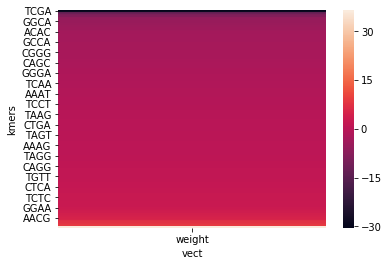

In [5]:
##################################################
# Plot the weight for each kmer as a heatmap
##################################################

kmers_df = pd.DataFrame({'kmers': kmers_sort, 'weights':model.coef_, 'vect':['weight'] * len(kmers_sort) })
kmers_df = kmers_df.pivot(index='kmers', columns='vect', values='weights')
sns.heatmap(kmers_df.sort_values('weight'))


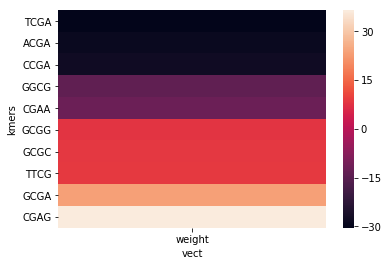

In [6]:
##################################################
# Plot the weight for the best and worst kmers
##################################################

kmers_df = pd.DataFrame({'kmers': kmers_sort, 'weights':model.coef_, 'vect':['weight'] * len(kmers_sort) })
frames = [kmers_df.sort_values('weights')[0:5], kmers_df.sort_values('weights')[-5:]]
filtered_kmers_df = pd.concat(frames)
filtered_kmers_df = filtered_kmers_df.pivot(index='kmers', columns='vect', values='weights')
sns.heatmap(filtered_kmers_df.sort_values('weight'))